In [1]:
import numpy as np
import matplotlib.pyplot as plt
import graphlearning as gl
from al_util import *
from graph_util import *
import scipy.sparse as sparse

In [2]:
%load_ext autoreload

In [3]:
%autoreload

In [4]:
X, digits = gl.datasets.load('mnist', metric='vae')

In [5]:
W = gl.weightmatrix.knn(X, 20)
G = gl.graph(W)

In [6]:
deg = G.degree_vector()

In [7]:
evals, evecs = G.eigen_decomp(normalization='normalized', k=100, method='lowrank', q=150)

KeyboardInterrupt: 

# Binary Test -- Odd vs Even

In [35]:
labels = digits.copy()
labels[labels % 2 == 0] = 0
labels[labels % 2 == 1] = 1

labeled_ind = gl.trainsets.generate(labels, 1)
c0_ind, c1_ind = labeled_ind[labels[labeled_ind] == 0], labeled_ind[labels[labeled_ind] == 1]

In [36]:
unlabeled_ind = np.delete(np.arange(labels.size), labeled_ind)

In [37]:
alpha, beta = prop_alpha_beta_thresh(evecs, evals, c0_ind, c1_ind, .1, thresh=1e-9)
p = (alpha+1.)/(alpha + beta+2.)
p[np.isnan(p)] = 0.5

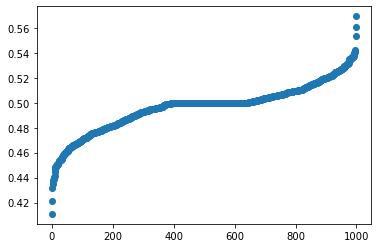

In [38]:
plt.scatter(np.arange(1000), np.sort(p[np.random.choice(np.arange(W.shape[0]), 1000)]))

In [15]:
%%timeit
# with 500 points per digit
beta_vopt_vals = beta_look_ahead_acquisition(alpha, beta, evecs, evals, unlabeled_ind, classifier='mean', \
                                        method='vopt', dt=.1)


1.75 s ± 44.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
%%timeit
# with 1000 points per digit
beta_ryan_vals = beta_look_ahead_acquisition(alpha, beta, evecs, evals, unlabeled_ind, classifier='mean', \
                                        method='ryan', dt=.1, show=False, thresh=1e-9)

1.78 s ± 69.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
%%timeit
# with full dataset
beta_deg_var_vals = beta_look_ahead_acquisition(alpha, beta, evecs, evals, unlabeled_ind, classifier='mean', \
                                        method='deg-var', dt=.1, show=False, thresh=1e-9, deg=deg)

540 µs ± 27.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Observations

Only the degree-weighted variance calculations seem to be fast enough for me to reasonably run this. This isn't too bad I guess, because it's the main one that I want to run.

In [46]:
# Accuracies with Current Labeled Set
ll_model = gl.ssl.laplace(G)
ll_pred_labels = ll_model.fit_predict(labeled_ind, labels[labeled_ind])

accuracy = gl.ssl.ssl_accuracy(pred_labels, labels, len(labeled_ind))   
print("LL Accuracy: %.2f%%"%accuracy)

LL Accuracy: 60.56%


In [47]:
pl_model = gl.ssl.poisson(G)
pl_pred_labels = pl_model.fit_predict(labeled_ind, labels[labeled_ind])

accuracy = gl.ssl.ssl_accuracy(pred_labels, labels, len(labeled_ind))   
print("PL Accuracy: %.2f%%"%accuracy)

PL Accuracy: 60.56%


In [49]:
u_laplace = ll_model.fit(labeled_ind, labels[labeled_ind])
u_poisson = pl_model.fit(labeled_ind, labels[labeled_ind])

gamma = 0.5
C_a = np.linalg.inv(np.diag(evals) + evecs[labeled_ind,:].T @ evecs[labeled_ind,:] / gamma**2.) # M by M covariance matrix

In [50]:
%%timeit 
vopt_vals = acquisition_function(C_a, evecs, unlabeled_ind, u_laplace, method='vopt', gamma=gamma)

238 ms ± 4.23 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [51]:
%%timeit 
laplace_uncertainty_vals = acquisition_function(C_a, evecs, unlabeled_ind, u_laplace, method='uncertainty', \
                                                uncertainty_method='smallest_margin', gamma=gamma)

1.77 ms ± 39.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [52]:
%%timeit
poisson_uncertainty_vals = acquisition_function(C_a, evecs, unlabeled_ind, u_poisson, method='uncertainty', \
                                                uncertainty_method='smallest_margin', gamma=gamma)

2.01 ms ± 27.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [290]:
deg = G.degree_vector()
deg = (deg - deg.min())/(deg.max() - deg.min())

In [291]:
print(beta_var_acc_.size)

101


In [296]:
%autoreload

In [297]:
beta_var_acc_, beta_var_labeled_ind, beta_var_acc_ll_ = al_test(W, X, labeled_ind, labels, evecs, evals, al_iters=100, method='var', classifier='mean', \
            kernel='heat', dt=.5, thresh=1e-9, show=False, return_ll=True)
print('beta var done')
beta_deg_var_acc_, beta_deg_var_labeled_ind, beta_deg_var_acc_ll_ = al_test(W, X, labeled_ind, labels, evecs, evals, al_iters=100, method='deg-var', classifier='mean', \
            kernel='heat', dt=.5, thresh=1e-9, show=False, return_ll=True, deg=deg)
print('beta deg var done')
# vopt_acc_, vopt_labeled_ind = al_test_gl(W, X, labeled_ind, labels, evecs, evals, al_iters=100, method='vopt', \
#             show=False, gamma=0.5, algorithm='poisson')
# print('vopt done')
# uncertainty_acc_, uncertainty_labeled_ind = al_test_gl(W, X, labeled_ind, labels, evecs, evals, al_iters=100, method='uncertainty', \
#             show=False, gamma=0.5)
# print('ll unc done')
# poisson_uncertainty_acc_, poisson_uncertainty_labeled_ind = al_test_gl(W, X, labeled_ind, labels, evecs, evals, al_iters=100, method='uncertainty', \
#             algorithm='poisson', show=False, gamma=0.5)

return_ll will return poisson learning
beta var done
return_ll will return poisson learning
beta deg var done


In [298]:
print("pl unc done")

pl unc done


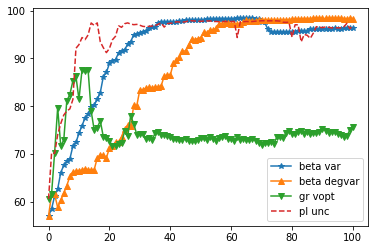

In [324]:
# NEW, with beta having better evals evecs
dom = np.arange(beta_var_acc_.size)
plt.plot(dom, beta_var_acc_, '-*', label='beta var', linewidth=1.5)
plt.plot(dom, beta_deg_var_acc_, '-^', label='beta degvar', linewidth=1.5)
plt.plot(dom, vopt_acc_, '-v', label='gr vopt', linewidth=1.5)
# plt.plot(dom, uncertainty_acc_, '-o', label='ll unc', linewidth=1.5)
plt.plot(dom, poisson_uncertainty_acc_, '--', label='pl unc', linewidth=1.5)
plt.legend()
plt.show()

In [313]:
print(labels[beta_var_labeled_ind])
print(labels[poisson_uncertainty_labeled_ind])

[0 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 1 0 0 1 0 1 1 1 1 1 0 0 0 1 0 0 1 1 1 0
 1 1 1 0 0 0 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0 1 0 1 1 1 0
 1 0 0 1 1 0 0 1 1 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0 1 1 1 0]
[0 1 1 1 0 0 1 0 1 1 1 1 1 0 0 1 1 1 0 0 1 0 0 1 1 1 1 1 0 0 1 1 0 1 0 1 0
 0 1 0 1 1 1 1 0 1 1 0 1 0 0 0 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1
 1 0 0 0 1 0 0 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 0 0 1 0 1]


[0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1.
 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0.
 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1.
 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1.
 0. 0. 1. 0. 0. 1.]


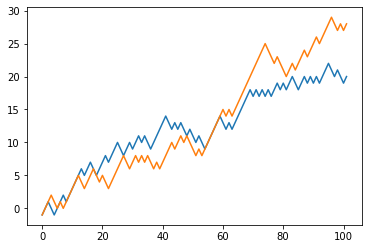

In [322]:
a, b = labels[beta_deg_var_labeled_ind].copy().astype(float), labels[poisson_uncertainty_labeled_ind].copy().astype(float)
print(a)
a[a == 0] = -1
b[b == 0] = -1

plt.plot(range(a.size), np.cumsum(a))
plt.plot(range(a.size), np.cumsum(b))
plt.show()

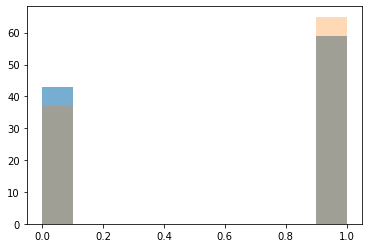

In [315]:
plt.hist(labels[beta_var_labeled_ind], label='beta var', alpha=0.6)
plt.hist(labels[poisson_uncertainty_labeled_ind], label='p unc', alpha=0.3)

plt.show()

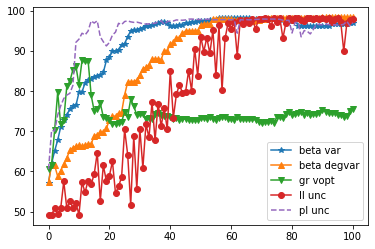

In [285]:
# NEW, with beta having better evals evecs
dom = np.arange(beta_var_acc_.size)
plt.plot(dom, beta_var_acc_, '-*', label='beta var', linewidth=1.5)
plt.plot(dom, beta_deg_var_acc_, '-^', label='beta degvar', linewidth=1.5)
plt.plot(dom, vopt_acc_, '-v', label='gr vopt', linewidth=1.5)
plt.plot(dom, uncertainty_acc_, '-o', label='ll unc', linewidth=1.5)
plt.plot(dom, poisson_uncertainty_acc_, '--', label='pl unc', linewidth=1.5)
plt.legend()
plt.show()

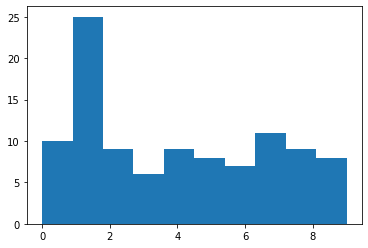

In [276]:
plt.hist(digits[beta_var_labeled_ind])
plt.show()

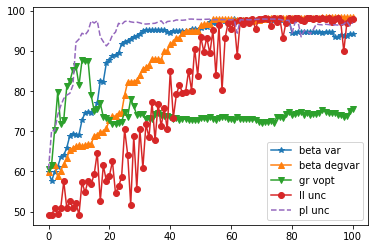

In [241]:
# NEW, with beta having better evals evecs
dom = np.arange(beta_var_acc_.size)
plt.plot(dom, beta_var_acc_, '-*', label='beta var', linewidth=1.5)
plt.plot(dom, beta_deg_var_acc_, '-^', label='beta degvar', linewidth=1.5)
plt.plot(dom, vopt_acc_, '-v', label='gr vopt', linewidth=1.5)
plt.plot(dom, uncertainty_acc_, '-o', label='ll unc', linewidth=1.5)
plt.plot(dom, poisson_uncertainty_acc_, '--', label='pl unc', linewidth=1.5)
plt.legend()
plt.show()

In [215]:
np.savez("Lnormevals_test.npz", bv_labeled=beta_var_labeled_ind, bdv_labeled=beta_deg_var_labeled_ind, \
                            vopt_labeled=vopt_labeled_ind, llu_labeled=uncertainty_labeled_ind, \
                            plu_labeled=poisson_uncertainty_labeled_ind)

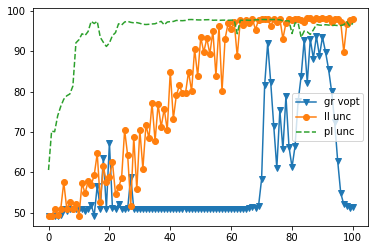

In [74]:
# OLD
dom = np.arange(beta_var_acc_.size)
# plt.plot(dom, beta_var_acc_ll_, '-*', label='beta var', linewidth=1.5)
# plt.plot(dom, beta_deg_var_acc_ll_, '-^', label='beta degvar', linewidth=1.5)
plt.plot(dom, vopt_acc_, '-v', label='gr vopt', linewidth=1.5)
plt.plot(dom, uncertainty_acc_, '-o', label='ll unc', linewidth=1.5)
plt.plot(dom, poisson_uncertainty_acc_, '--', label='pl unc', linewidth=1.5)
plt.legend()
plt.show()

In [236]:
model = gl.ssl.poisson(W)
pred_labels = model.fit_predict(beta_var_labeled_ind, labels[beta_var_labeled_ind])

bv_acc = gl.ssl.ssl_accuracy(pred_labels, labels, beta_var_labeled_ind.size)
print(f"Poisson acc for Beta Var Points: {bv_acc}")
pred_labels = model.fit_predict(beta_deg_var_labeled_ind, labels[beta_deg_var_labeled_ind])

bdv_acc = gl.ssl.ssl_accuracy(pred_labels, labels, beta_deg_var_labeled_ind.size)
print(f"Poisson acc for Beta DegVar Points: {bdv_acc}")

pred_labels = model.fit_predict(vopt_labeled_ind, labels[vopt_labeled_ind])
vopt_acc = gl.ssl.ssl_accuracy(pred_labels, labels, vopt_labeled_ind.size)
print(f"Poisson acc for Vopt Points: {vopt_acc}")

Poisson acc for Beta Var Points: 83.41011187730693
Poisson acc for Beta DegVar Points: 74.8962774328307
Poisson acc for Vopt Points: 75.59157629688976


In [75]:
def get_poisson_acc(W, labels, start_ind, chosen_inds):
    model = gl.ssl.poisson(W)
    pred_labels = model.fit_predict(start_ind, labels[start_ind])
    acc = np.array([])
    acc = np.append(acc, gl.ssl.ssl_accuracy(pred_labels, labels, start_ind.size))
    
    for i, idx in enumerate(chosen_inds):
        inds = np.concatenate((start_ind, chosen_inds[:i+1]))
        pred_labels = model.fit_predict(inds, labels[inds], spectral_cutoff=)
        acc = np.append(acc, gl.ssl.ssl_accuracy(pred_labels, labels, inds.size))
    
    return acc

In [76]:
bv_pacc = get_poisson_acc(W, labels, labeled_ind, beta_var_labeled_ind[2:])
bdv_pacc = get_poisson_acc(W, labels, labeled_ind, beta_deg_var_labeled_ind[2:])
vopt_pacc = get_poisson_acc(W, labels, labeled_ind, vopt_labeled_ind[2:])

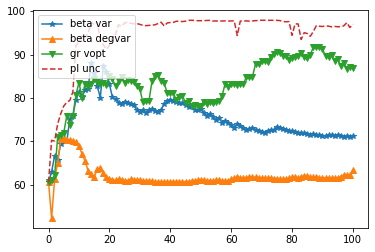

In [78]:
plt.plot(dom, bv_pacc, '-*', label='beta var', linewidth=1.5)
plt.plot(dom, bdv_pacc, '-^', label='beta degvar', linewidth=1.5)
plt.plot(dom, vopt_pacc, '-v', label='gr vopt', linewidth=1.5)
plt.plot(dom, poisson_uncertainty_acc_, '--', label='pl unc', linewidth=1.5)
plt.legend()
plt.show()

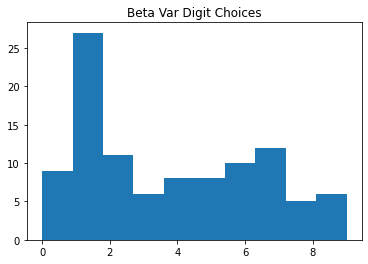

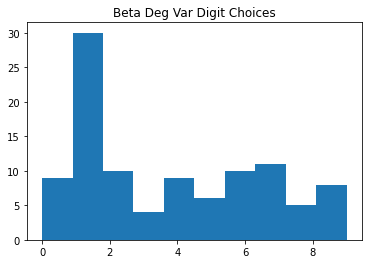

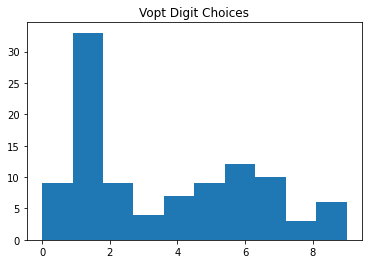

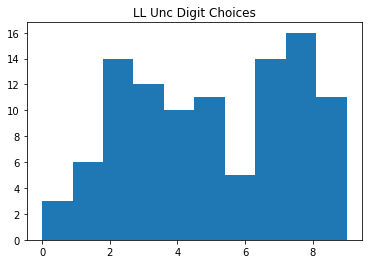

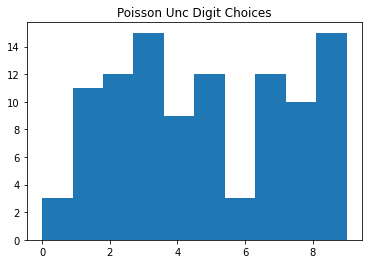

In [211]:
plt.hist(digits[beta_var_labeled_ind])
plt.title("Beta Var Digit Choices")
plt.show()

plt.hist(digits[beta_deg_var_labeled_ind])
plt.title("Beta Deg Var Digit Choices")
plt.show()

plt.hist(digits[vopt_labeled_ind])
plt.title("Vopt Digit Choices")
plt.show()

plt.hist(digits[uncertainty_labeled_ind])
plt.title("LL Unc Digit Choices")
plt.show()

plt.hist(digits[poisson_uncertainty_labeled_ind])
plt.title("Poisson Unc Digit Choices")
plt.show()

## To Try:
* Normalized Graph Laplacian have better eigenvalues and eigenvectors for propagation on MNIST?
* More eigenvectors?
* Need to look into the Beta Learning classifier -- probably is not calculating something correctly... 
    * Seems to oversample in the "1" digit... why?
* Plot the poisson learning solution values, sorted to show how "far" away each of the unlabeled points are from the labeled.. Poisson learning in a sense is doing what I'm trying to do with Beta Learning with propagation. Maybe the Beta Learning propagation isn't working correctly with the random svd eigenvectors?

In [82]:
digit_sorted_idx = np.argsort(digits)

In [83]:
digit_sorted_idx[:5]

array([34999, 56424, 56419, 16705, 56415])

In [84]:
digits[:5]

array([5, 0, 4, 1, 9], dtype=uint8)

In [85]:
print(digits[digit_sorted_idx[:5]])

[0 0 0 0 0]


In [86]:
c0_ind

array([40687])

In [125]:
sorted_labels = labels[digit_sorted_idx]

In [126]:
sorted_labeled_ind = np.where(np.isin(digit_sorted_idx, labeled_ind))[0]

In [181]:
evals, evecs = G.eigen_decomp(normalization='normalized', k=100, method='lowrank', q=150)

In [200]:
%autoreload

In [201]:
alpha, beta = prop_alpha_beta_thresh(evecs, evals, c0_ind, c1_ind, 1., thresh=1e-5, kernel='diffuse')
p = (alpha+1.)/(alpha + beta+2.)
p[np.isnan(p)] = 0.5

diffuse
[100.          79.80359896  72.06033295  66.4577744   64.40556943
  63.78410035  59.07723364  55.72866047  48.11604923  47.46407772
  46.48275832  44.52981932  41.0884319   39.66069849  36.35185139
  34.90280581  33.59933751  33.51497698  32.9844376   32.78010464
  31.32150725  30.50039407  29.67709045  28.73345341  28.67277623
  28.09163429  27.54299559  27.13627177  26.47880014  26.17669821
  25.49713374  25.43788846  25.21235351  24.42047203  24.14366493
  23.60006024  23.50452325  23.3977173   23.00201187  22.92999023
  22.64715864  22.53520401  22.37016062  22.30591084  21.75533604
  21.73204619  21.66155455  20.66503929  20.50086934  20.30347665
  20.15103229  19.91839709  19.82897445  19.72066739  19.69306261
  19.59961659  19.26628985  19.09555788  18.87449463  18.80085311
  18.68078532  18.60835438  18.50434188  18.44821583  18.31967385
  18.21258425  18.14572862  18.11715008  17.79371971  17.68853971
  17.32836248  17.22538342  17.19137486  17.15161711  16.94795868
  

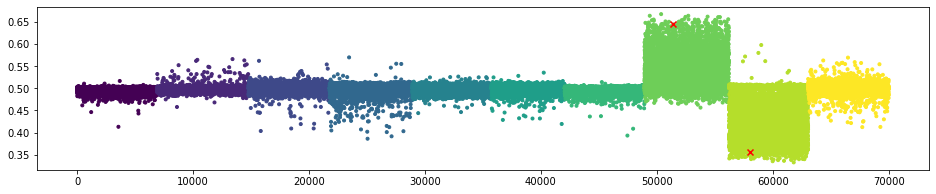

61799 [51428 58037]
[8.88178420e-16 2.53076319e-03 3.87726033e-03 5.04714849e-03
 5.52660754e-03 5.67788829e-03 6.92699435e-03 7.94408822e-03
 1.07830862e-02 1.10685649e-02]


In [202]:
# normalized graph Laplacian, 100 evals, dt = 0.01 heat kernel
dom = np.arange(p.size)
fig, ax = plt.subplots(figsize=(16,3))
ax.scatter(dom, p[digit_sorted_idx], marker='.', c=digits[digit_sorted_idx])
ax.scatter(sorted_labeled_ind, p[digit_sorted_idx][sorted_labeled_ind], marker='x', c='r')
plt.show()

print(np.argmin(p[digit_sorted_idx]), sorted_labeled_ind)
print(evals[:10])

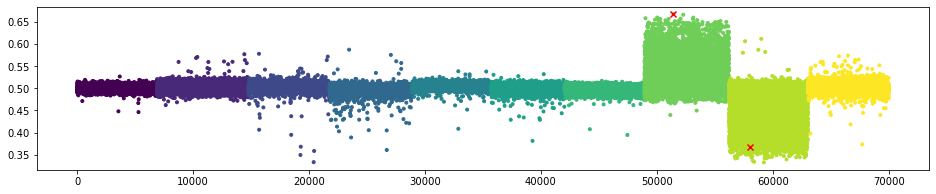

59223 [51428 58037]
[6.02154525e-06 5.24668935e-03 7.41746745e-03 9.62551516e-03
 1.06377291e-02 1.18416648e-02 1.33179794e-02 1.51038099e-02
 2.04865987e-02 2.16638540e-02]


In [180]:
# combinatorial graph Laplacian, 100 evals, dt = 0.01 heat kernel
dom = np.arange(p.size)
fig, ax = plt.subplots(figsize=(16,3))
ax.scatter(dom, p[digit_sorted_idx], marker='.', c=digits[digit_sorted_idx])
ax.scatter(sorted_labeled_ind, p[digit_sorted_idx][sorted_labeled_ind], marker='x', c='r')
plt.show()

print(np.argmin(p[digit_sorted_idx]), sorted_labeled_ind)
print(evals[:10])

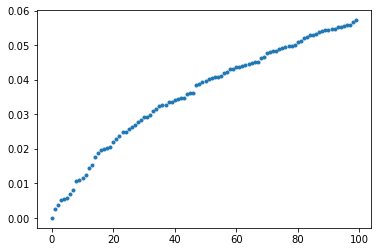

In [173]:
plt.scatter(np.arange(len(evals)), evals, marker='.')
plt.show()

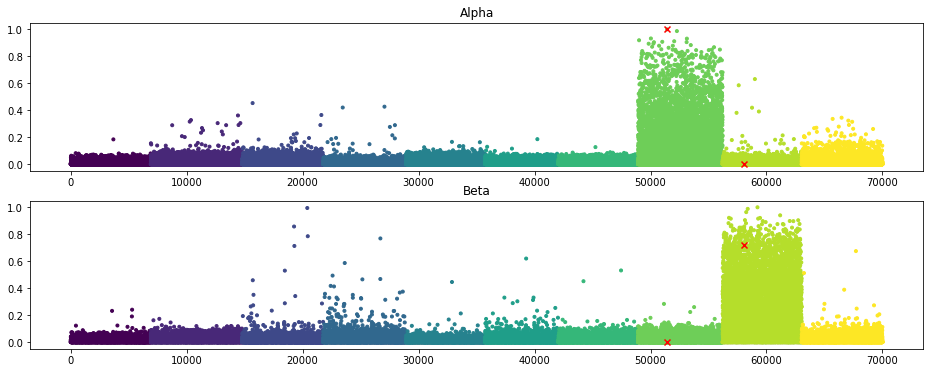

In [177]:
dom = np.arange(p.size)
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(16,6))
ax1.scatter(dom, alpha[digit_sorted_idx], marker='.', c=digits[digit_sorted_idx])
ax1.scatter(sorted_labeled_ind, alpha[digit_sorted_idx][sorted_labeled_ind], marker='x', c='r')
ax1.set_title("Alpha")
ax2.scatter(dom, beta[digit_sorted_idx], marker='.', c=digits[digit_sorted_idx])
ax2.scatter(sorted_labeled_ind, beta[digit_sorted_idx][sorted_labeled_ind], marker='x', c='r')
ax2.set_title("Beta")
plt.show()

In [216]:
train_inds = np.load('Lnormevals_test.npz')

In [217]:
for name in train_inds.keys():
    all_labeled = train_inds[name]
    print(all_labeled)
    break

[40687 62577     5     6    66    72    92   208  1054  1602 13069 31705
 67250 32277 40249 19774 60279 28542 29369 61854 36059 23530 69719 61989
 43147 18463 50987 21574 12909 19177 46165 37543 69852 34476 23255 66683
 53499 12879  4587 60898 54506 34749 25869 13470  8817 23852 59266  2118
  2606 28846 11224 53025  5982 34843 65778  6595 32104 10554 64909 22700
 19828 13558 49304 28231 22976 32003 12742 63598 58419 48297 66461  3593
 27585 36056 29609 48657 51898 19950 61422 39898 57931 25955  7201 10291
 19278 13449 17137  9022 12436 65936 58143 47433 48656 40632  7010 46906
 26452 25232 64924 49070 30255 48460]


In [220]:
import pandas as pd

In [228]:
num_start = 2
modelname = 'beta'

if modelname == 'poisson':
    model = gl.ssl.poisson(G)

ACCS = {}
for name in train_inds.keys():
    print(name)
    all_labeled = train_inds[name]
    accs = []
    for i in range(2,len(all_labeled)):
        train_ind = all_labeled[:i]
        if modelname == 'beta':
            c0_ind, c1_ind = train_ind[labels[train_ind] == 0], train_ind[labels[train_ind] == 1]
            alpha, beta = prop_alpha_beta_thresh(evecs, evals, c0_ind, c1_ind, .1, thresh=1e-9)
            u = (alpha+1.)/(alpha + beta+2.)
            u[np.isnan(u)] = 0.5 + 0.0001*np.random.randn(np.isnan(u).sum())
        else:
            u = model.fit(train_ind, labels[train_ind])
            
        accs.append(gl.ssl.ssl_accuracy(1*(u >= 0.5), labels, train_ind.size))
    ACCS[name] = np.array(accs)

acc_df = pd.DataFrame(ACCS)

bv_labeled
bdv_labeled
vopt_labeled
llu_labeled
plu_labeled


In [245]:
num_start = 2
modelname = 'poisson'

if modelname == 'poisson':
    model = gl.ssl.poisson(G)

ACCS = {}
for name in train_inds.keys():
    print(name)
    all_labeled = train_inds[name]
    accs = []
    for i in range(2,len(all_labeled)):
        train_ind = all_labeled[:i]
        if modelname == 'beta':
            c0_ind, c1_ind = train_ind[labels[train_ind] == 0], train_ind[labels[train_ind] == 1]
            alpha, beta = prop_alpha_beta_thresh(evecs, evals, c0_ind, c1_ind, .1, thresh=1e-9)
            u = (alpha+1.)/(alpha + beta+2.)
            u[np.isnan(u)] = 0.5 + 0.0001*np.random.randn(np.isnan(u).sum())
            accs.append(gl.ssl.ssl_accuracy(1*(u[:,1] >= 0.5), labels, train_ind.size))
        else:
            u = model.fit(train_ind, labels[train_ind])[:,-1]
            accs.append(gl.ssl.ssl_accuracy(1*(u >= 0.), labels, train_ind.size))
    ACCS[name] = np.array(accs)

acc_df_poisson = pd.DataFrame(ACCS)

bv_labeled
bdv_labeled
vopt_labeled


KeyboardInterrupt: 

In [229]:
acc_df.head()

,bv_labeled,bdv_labeled,vopt_labeled,llu_labeled,plu_labeled
0,59.963142,59.963142,59.963142,59.963142,59.963142
1,60.799749,60.381159,60.685458,61.019758,60.789748
2,61.457798,58.527630,60.972056,61.213498,61.013486
3,61.892992,57.779841,64.048861,60.902922,60.208586
4,62.436780,55.564763,64.846987,60.989513,61.150956


In [250]:
acc_df_poisson = pd.DataFrame(ACCS)
acc_df_poisson['vopt_labeled'] = vopt_acc_[:-1]
acc_df_poisson['llu_labeled'] = uncertainty_acc_[:-1]
acc_df_poisson['plu_labeled'] = poisson_uncertainty_acc_[:-1]

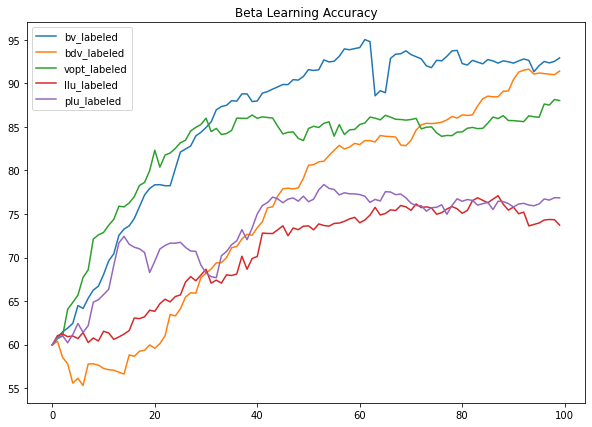

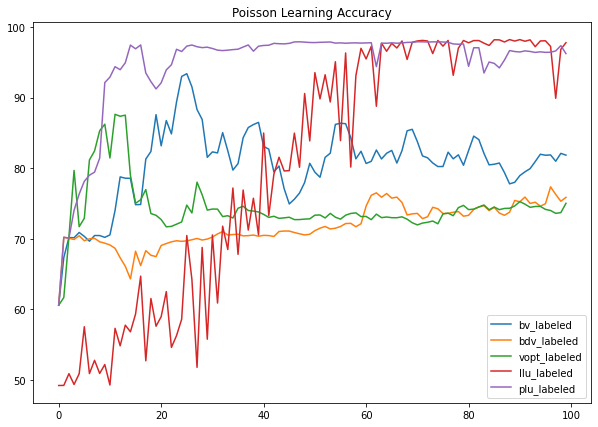

In [251]:
fig, ax = plt.subplots(figsize=(10,7))
acc_df.plot(ax=ax, title='Beta Learning Accuracy')
plt.show()

fig, ax = plt.subplots(figsize=(10,7))
acc_df_poisson.plot(ax=ax, title='Poisson Learning Accuracy')
plt.show()

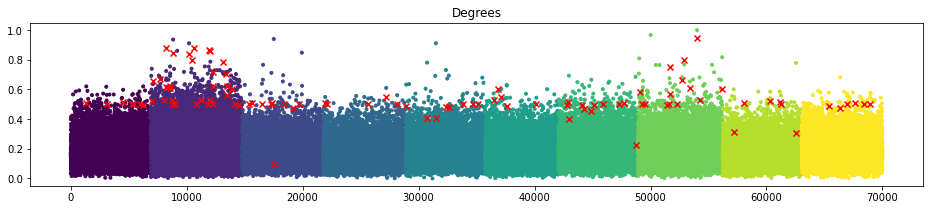

In [328]:
train_ind = all_labeled_ind[:]
sorted_train_ind = np.where(np.isin(digit_sorted_idx, train_ind))[0]

fig, ax = plt.subplots(figsize=(16,3))
ax.scatter(dom, deg[digit_sorted_idx], marker='.', c=digits[digit_sorted_idx])
ax.scatter(sorted_train_ind, u[digit_sorted_idx][sorted_train_ind], marker='x', c='r')
ax.set_title(f"Degrees")
plt.show()

In [ ]:
train_ind = all_labeled_ind[:]
sorted_train_ind = np.where(np.isin(digit_sorted_idx, train_ind))[0]

candidate_ind = np.arange(G.num_nodes)
Sigma = evecs * np.exp(-0.1*evals)[np.newaxis, :]
weights = Sigma @ evecs.T[:,candidate_ind] # pretty darn large, would need to distribute in larger problems for memory issues
weights[weights < 1e-9] = 0.0
weights /= weights.max(axis=0)[np.newaxis, :]
influence = np.linalg.norm(weights, axis=0)


fig, ax = plt.subplots(figsize=(16,3))
ax.scatter(dom, deg[digit_sorted_idx], marker='.', c=digits[digit_sorted_idx])
ax.scatter(sorted_train_ind, u[digit_sorted_idx][sorted_train_ind], marker='x', c='r')
ax.set_title(f"Influence")
plt.show()

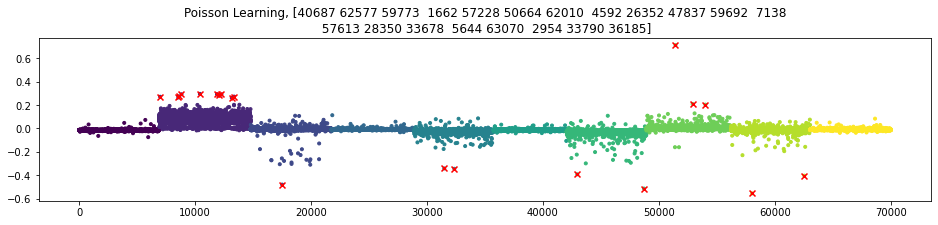

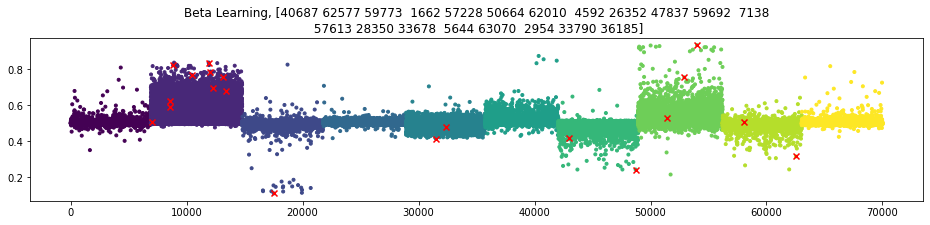

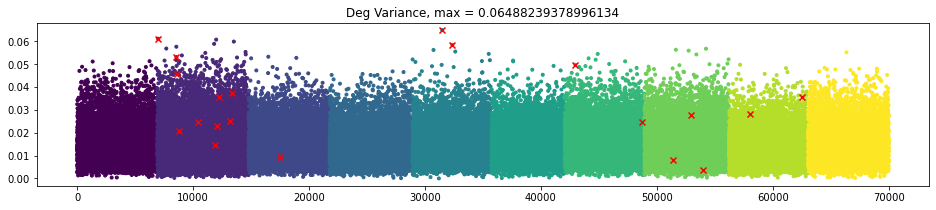

--------------------------------------------------


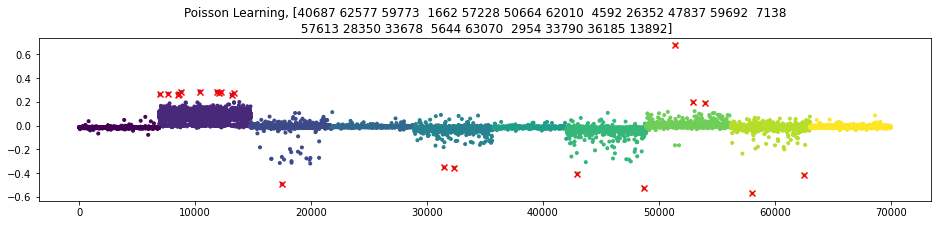

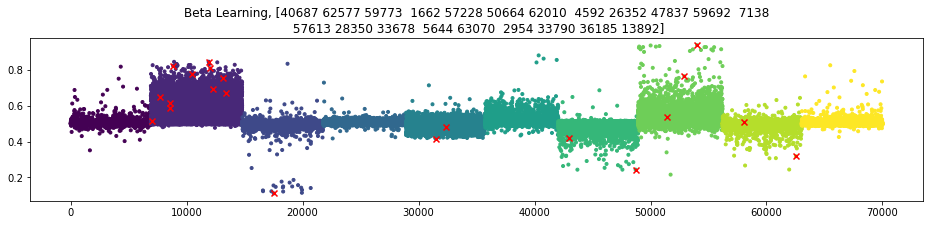

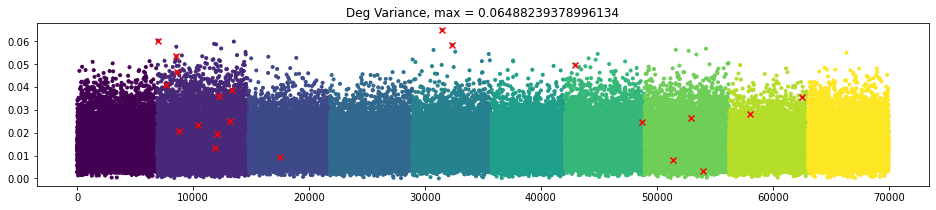

--------------------------------------------------


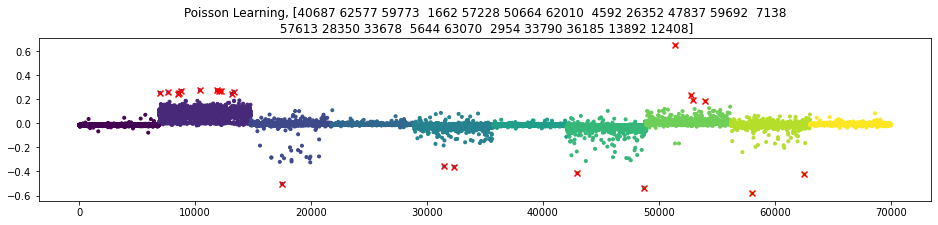

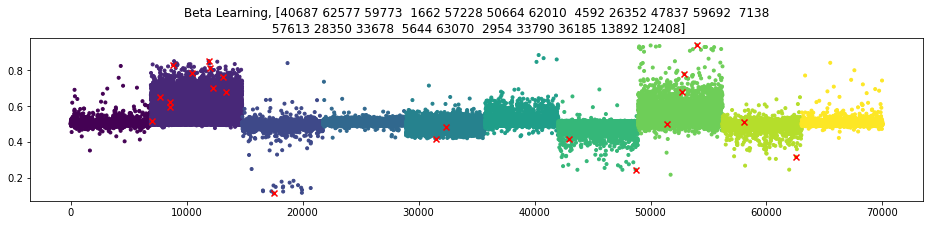

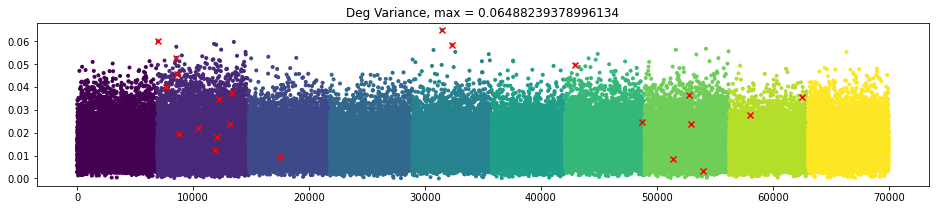

--------------------------------------------------


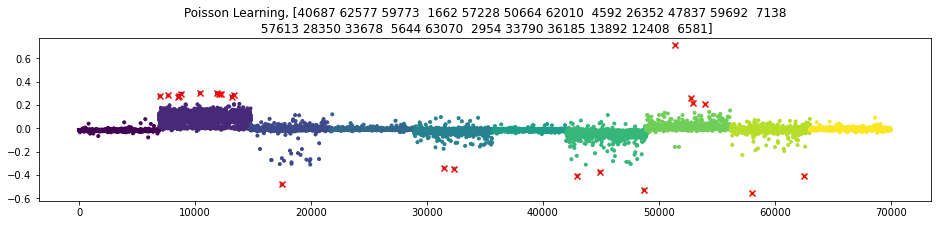

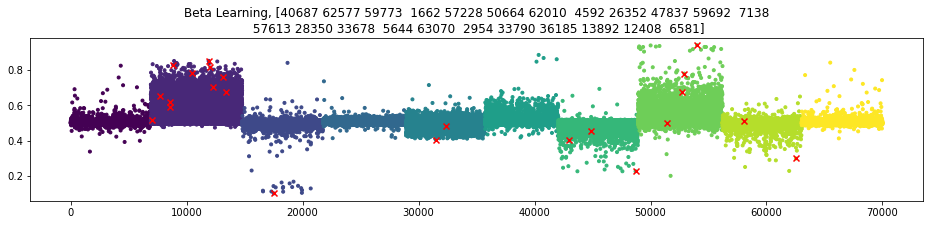

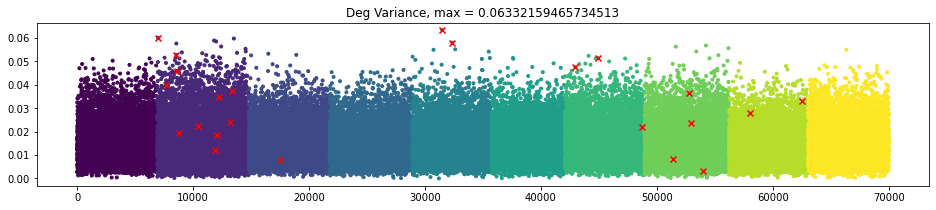

--------------------------------------------------


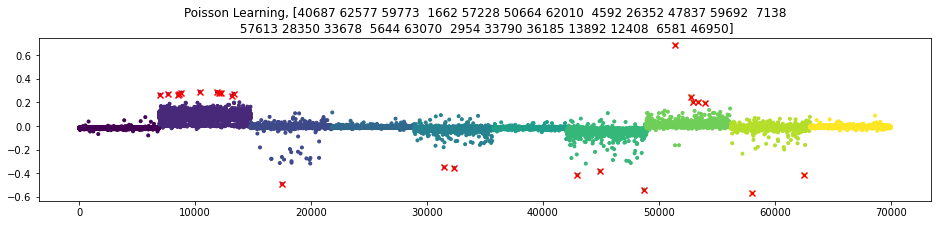

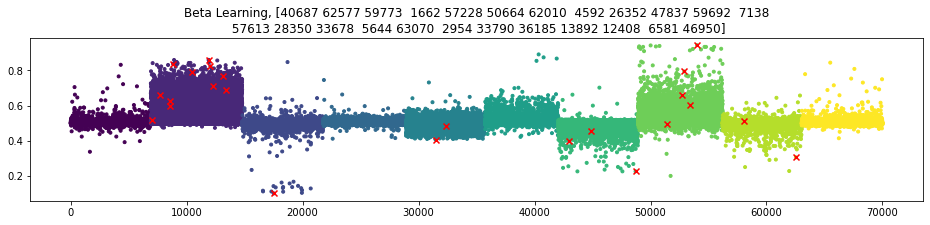

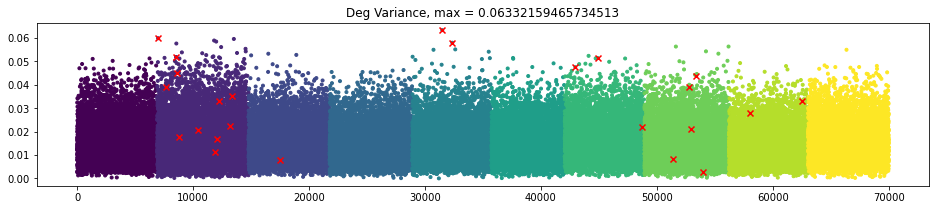

--------------------------------------------------


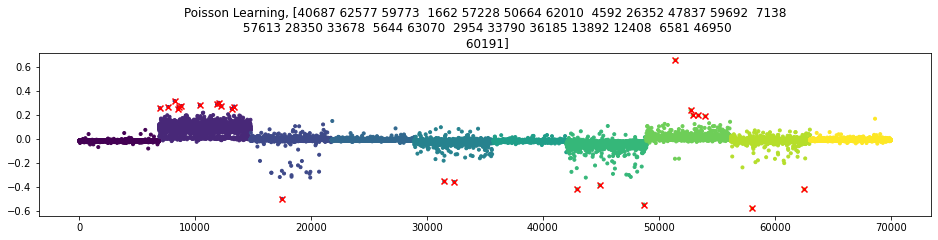

KeyboardInterrupt: 

In [326]:
pl_model = gl.ssl.poisson(G)
all_labeled_ind = beta_deg_var_labeled_ind
%matplotlib inline

for i in range(20, 30):
    train_ind = all_labeled_ind[:i]
    sorted_train_ind = np.where(np.isin(digit_sorted_idx, train_ind))[0]
    
    u = pl_model.fit(train_ind, labels[train_ind])[:,-1]
    dom = np.arange(u.size)
    fig, ax = plt.subplots(figsize=(16,3))
    ax.scatter(dom, u[digit_sorted_idx], marker='.', c=digits[digit_sorted_idx])
    ax.scatter(sorted_train_ind, u[digit_sorted_idx][sorted_train_ind], marker='x', c='r')
    ax.set_title(f"Poisson Learning, {train_ind}")
    plt.show()
    
    c0_ind, c1_ind = train_ind[labels[train_ind] == 0], train_ind[labels[train_ind] == 1]
    alpha, beta = prop_alpha_beta_thresh(evecs, evals, c0_ind, c1_ind, .1, thresh=1e-9)
    u = (alpha+1.)/(alpha + beta+2.)
    u[np.isnan(u)] = 0.5 + 0.0001*np.random.randn(np.isnan(u).sum())
    
    dom = np.arange(u.size)
    fig, ax = plt.subplots(figsize=(16,3))
    ax.scatter(dom, u[digit_sorted_idx], marker='.', c=digits[digit_sorted_idx])
    ax.scatter(sorted_train_ind, u[digit_sorted_idx][sorted_train_ind], marker='x', c='r')
    ax.set_title(f"Beta Learning, {train_ind}")
    plt.show()
    
    dom = np.arange(u.size)
    u = (alpha + 1.)*(beta + 1.)/((alpha + beta + 2.)**2. * (alpha + beta + 3.))
    u *= deg
    fig, ax = plt.subplots(figsize=(16,3))
    ax.scatter(dom, u[digit_sorted_idx], marker='.', c=digits[digit_sorted_idx])
    ax.scatter(sorted_train_ind, u[digit_sorted_idx][sorted_train_ind], marker='x', c='r')
    ax.set_title(f"Deg Variance, max = {np.max(u)}")
    plt.show()
    
# #     u = (alpha + 1.)*(beta + 1.)/((alpha + beta + 2.)**2. * (alpha + beta + 3.))
#     dom = np.arange(u.size)
#     fig, ax = plt.subplots(figsize=(16,3))
#     ax.scatter(dom, u, marker='.', c=digits)
#     ax.scatter(train_ind, u[train_ind], marker='x', c='r')
#     ax.set_title(f"Variance (Not Ordered), {train_ind}")
# #     ax.set_xlim(-1,10)
#     plt.show()
    print("-"*50)

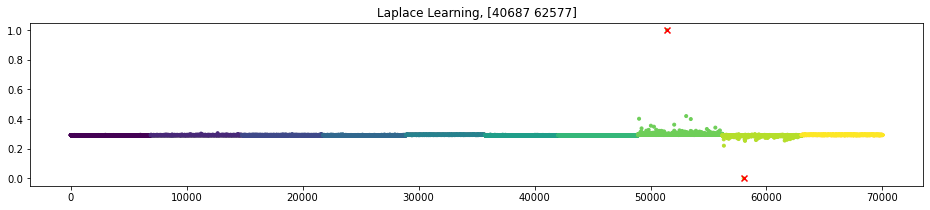

In [239]:
model = gl.ssl.laplace(G)
u = model.fit(labeled_ind, labels[labeled_ind])[:,-1]

dom = np.arange(p.size)
fig, ax = plt.subplots(figsize=(16,3))
ax.scatter(dom, u[digit_sorted_idx], marker='.', c=digits[digit_sorted_idx])
ax.scatter(sorted_labeled_ind, u[digit_sorted_idx][sorted_labeled_ind], marker='x', c='r')
ax.set_title(f"Laplace Learning, {labeled_ind}")
plt.show()

In [267]:
obj_vals = np.random.randn(100)
obj_vals[45:67] = np.max(obj_vals) + 1e-12*np.random.randn(22)

In [269]:
mask = np.isclose(obj_vals, np.max(obj_vals))

In [270]:
print(mask.sum())

23


In [ ]:
def poisson_weight(G, train_ind, ti_labels):
    n = G.num_nodes
    F = np.zeros((n,np.max(ti_labels)+1))
    for idx, lbl in zip(train_ind, ti_labels):
    f[idx] = 1
    f -= np.mean(f)

    L = G.laplacian()
    w = gl.utils.conjgrad(L, f, tol=1e-5)
    return w

# Multiclass Beta Learning

In [ ]:
def prop_alpha_beta_thresh(V, Lam, c0_ind, c1_ind, dt, kernel='heat', thresh=1e-9):
    '''
    Propagate from labeled points to get alpha and beta, the "amount of mass" of success/failure for each node in graph
    '''
    if kernel == 'heat':
        Sigma = V * np.exp(-dt*Lam)[np.newaxis, :]
    elif kernel == 'diffuse':
        Sigma = V / (1.+dt*Lam)[np.newaxis, :]
    else:
        raise ValueError(f"kernel = {kernel} not valid kernel option")
    
    beta = Sigma @ (V.T[:,c0_ind]).sum(axis=1)
    alpha = Sigma @ (V.T[:,c1_ind]).sum(axis=1)
#     print(alpha.min(), alpha.max(), beta.min(), beta.max())
    if thresh:
        beta[beta < thresh] = 0.0
        alpha[alpha < thresh] = 0.0
        beta /= beta.max()/c0_ind.size
        alpha /= alpha.max()/c1_ind.size
    return alpha, beta


def beta_look_ahead_acquisition(alpha, beta, V, Lam, candidate_ind, classifier='mode', method='vopt', dt=1., kernel='heat', thresh=1e-9, gamma=None, show=False, deg=None, X=None, c0_ind=None, c1_ind=None):
    
    assert method in ['vopt', 'ryan', 'var', 'deg-var', 'mc-avg', 'mc-map'] 
    assert classifier in ['mode', 'mean']
    
    if method == 'mc-avg':
        def beta_mc(k, p):
            alpha0, beta0 = prop_alpha_beta_thresh(V, Lam, np.append(c0_ind, k), c1_ind, dt=0.5, kernel='heat', thresh=1e-9)
            alpha1, beta1 = prop_alpha_beta_thresh(V, Lam, c0_ind, np.append(c1_ind, k), dt=0.5, kernel='heat', thresh=1e-9)

            avg = p[k]*(alpha1+1.)/(alpha1 + beta1 + 2.) + (1.-p[k])*(alpha0 + 1.)/(alpha0 + beta0 + 2.)

            return np.linalg.norm(p - avg)
        u = (alpha + 1.)/(alpha + beta + 2.)
        return np.array([beta_mc(k, u) for k in candidate_ind])


    if method == 'mc-map':
        def beta_mc_map(k, p, yk):
            if yk == 0:
                alpha, beta = prop_alpha_beta_thresh(V, Lam, np.append(c0_ind, k), c1_ind, dt=0.5, kernel='heat', thresh=1e-9)
            else:
                alpha, beta = prop_alpha_beta_thresh(V, Lam, c0_ind, np.append(c1_ind, k), dt=0.5, kernel='heat', thresh=1e-9)

            return np.linalg.norm(p - (alpha + 1.)/(alpha + beta + 2.))
        u = (alpha + 1.)/(alpha + beta + 2.)
        y = 1*(u > 0.5)
        return np.array([beta_mc_map(k, u, y[k]) for k in candidate_ind])
        
        
       
    
    if method == "deg-var":
        assert deg is not None
        var = (alpha + 1.)*(beta + 1.)/((alpha + beta + 2.)**2. * (alpha + beta + 3.))
        return deg[candidate_ind] * var[candidate_ind]
    if method == "var":
        var = (alpha + 1.)*(beta + 1.)/((alpha + beta + 2.)**2. * (alpha + beta + 3.))
        return var[candidate_ind]
    
    if gamma is not None and thresh is not None:
        print("Both gamma and thresh were specified, defaulting to threshold.")
        gamma = None
    
    if gamma is None and thresh is None:
        print("Both gamma and thresh were set as None, defaulting to threshold = 0.01")
        thresh = 0
    
    if kernel == 'heat':
        Sigma = V * np.exp(-dt*Lam)[np.newaxis, :]
    elif kernel == 'diffuse':
        Sigma = V / (1.+dt*Lam)[np.newaxis, :]
    else:
        raise ValueError(f"kernel = {kernel} not valid kernel option")
    
    if classifier == 'mode':
        probs_candidate = alpha/(alpha + beta) # note alpha and beta are without the prior 1,1
        probs_candidate[np.isnan(probs_candidate)] = 0.5
    else:
        probs_candidate = (alpha + 1.)/(alpha + beta + 2.)
    
    weights = Sigma @ V.T[:,candidate_ind] # pretty darn large, would need to distribute in larger problems for memory issues
    if thresh:
        weights[weights < thresh] = 0.0
        weights /= weights.max(axis=0)[np.newaxis, :]
        
    if gamma: # should not occur if thresh is specified, per checks previously done
        weights = (1. + gamma*dt)*weights
    
    
    # not the most efficient, need to redo
    if method == 'ryan':
        influence = np.linalg.norm(weights, axis=0)
        var = (alpha + 1.)*(beta + 1.)/((alpha + beta + 2.)**2. * (alpha + beta + 3.))
#         if show and X is not None:
#             fig, (ax1, ax2) = two_scatter_plots(X, influence, var[candidate_ind], train_ind, train_ind, cand=candidate_ind)
#             ax1.set_title(f"Influence, dt = {dt}")
#             ax2.set_title("Current Variance")
#             plt.show()
        return var[candidate_ind] * influence
        
    betaks = weights + beta[:, np.newaxis] 
    alphaks = weights + alpha[:, np.newaxis] 
    
    result1 = ((alphaks + 1.) * (beta[:,np.newaxis] + 1.)) / ((alphaks + beta[:, np.newaxis] + 2.)**2. * (alphaks + beta[:,np.newaxis] + 3.))
    result0 = ((alpha[:,np.newaxis] + 1.)*(betaks+1.)) / ((alpha[:,np.newaxis] + betaks + 2.)**2. * (alpha[:,np.newaxis] + betaks + 3.))
    
    return -(probs_candidate[candidate_ind]*(result1).sum(axis=0) + (1. - probs_candidate[candidate_ind])*(result0).sum(axis=0)) # negative for max ordering